# Settings

## Installing dependencies

In [1]:
!pip install  datasets evaluate transformers[sentencepiece]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
t

## Import dependecies

In [2]:
# Data load
import os
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Preprocess
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

# Evaluate
import evaluate
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Train
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Inference
from transformers import pipeline

## Download corpus

In [3]:
dest_folder = "data"

file_nsf = "NSF"
file_dmoz = "Dmoz-Science"

# create folder
if not os.path.exists(dest_folder):
  os.mkdir(dest_folder)

# download file
if not os.path.exists(dest_folder + "/" + file_nsf + ".csv"):
  url = f"https://raw.githubusercontent.com/ragero/text-collections/refs/heads/master/complete_texts_csvs/{file_nsf}.csv"
  cmd = !wget -P {dest_folder} {url}

if not os.path.exists(dest_folder + "/" + file_dmoz + ".csv"):
  url = f"https://raw.githubusercontent.com/ragero/text-collections/refs/heads/master/complete_texts_csvs/{file_dmoz}.csv"
  cmd = !wget -P {dest_folder} {url}

# Text classification

## Utility functions

### Labels mapping

In [4]:
def get_label2id(labels):
    """
    Generate a dictionary mapping each label to a unique integer ID.

    Args:
        labels (list): List of label names.

    Returns:
        dict: Mapping of label names to integer IDs.
    """
    return {label: idx for idx, label in enumerate(labels)}


def get_id2label(labels):
    """
    Generate a dictionary mapping each integer ID to its corresponding label.

    Args:
        labels (list): List of label names.

    Returns:
        dict: Mapping of integer IDs to label names.
    """
    return {idx: label for idx, label in enumerate(labels)}



### Dataset initialization

In [25]:

def load_and_split_dataset(csv_file):
    """
    Load a dataset from a CSV file into a Hugging Face dataset, convert labels to integers,
    and split it into training (70%), validation (10%), and test (20%) sets.

    Args:
        csv_file (str): Path to the CSV file.

    Returns:
        DatasetDict: A Hugging Face dataset dictionary with train, validation, and test splits.
        dict: Mapping of label names to integer IDs.
        dict: Mapping of integer IDs to label names.
    """

    # Load CSV into a Pandas DataFrame
    df = pd.read_csv(csv_file)

    # Get unique labels and create a mapping
    unique_labels = sorted(df["class"].unique())  # Ensure consistent ordering
    label2id = get_label2id(unique_labels)
    id2label = get_id2label(unique_labels)

    # Replace "class" column values with integer IDs
    df["label"] = df["class"].map(label2id)

    # Keep only "text" and "label" columns
    df = df[["text", "label"]]

    # Split dataset: 70% train, 30% temp (validation + test)
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label"])

    # Further split temp dataset: 10% validation, 20% test
    val_df, test_df = train_test_split(temp_df, test_size=2/3, random_state=42, stratify=temp_df["label"])

    # Convert to Hugging Face datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    # Create a DatasetDict
    dataset_dict = DatasetDict({
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset
    })

    return dataset_dict, label2id, id2label  # Return dataset and labels mapping

### Preprocess

In [6]:
def preprocess_function(examples, tokenizer):
    """
    Preprocessing function to tokenize text and truncate sequences to be no longer than
    the model's maximum input length.

    Args:
        examples (dict): A dictionary containing a batch of text samples with the key "text".
        tokenizer: Used to tokenize the text.

    Returns:
        dict: A dictionary containing tokenized inputs, including input IDs and attention masks.
    """
    return tokenizer(examples["text"], truncation=True)


### Evaluation

In [7]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for model predictions.

    This function calculates F1-score by comparing the predicted labels with the true labels.
    The predictions are first converted to class indices using argmax, assuming they are
    probability distributions over classes.

    Args:
        eval_pred (tuple): A tuple containing:
            - predictions (numpy.ndarray): Model output logits or probabilities.
            - labels (numpy.ndarray): True labels.

    Returns:
        dict: A dictionary with the computed accuracy score.
    """
    accuracy = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute F1 scores
    f1_micro = f1_metric.compute(predictions=predictions, references=labels, average="micro")["f1"]
    f1_macro = f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]

    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    # Return the metrics
    return {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'accuracy': acc,
    }


## Corpus: Dmoz-Science

### Data load

In [8]:
ds_source = "data/Dmoz-Science.csv"
model_dir = "model_Dmoz-Science"

# Load dataset
data, label2id, id2label = load_and_split_dataset(ds_source)

print("Training size:", len(data["train"]))
print("Validation size:", len(data["validation"]))
print("Testing size:", len(data["test"]))

Training size: 4200
Validation size: 600
Testing size: 1200


Labels

In [9]:
# Compute the labels amount
qt_labels = len(label2id)

print("Number of labels:", qt_labels)
print(id2label)
print(label2id)

Number of labels: 12
{0: 'Agriculture', 1: 'Astronomy', 2: 'Biology', 3: 'Chemistry', 4: 'Earth', 5: 'Environment', 6: 'Instruments', 7: 'Math', 8: 'Physics', 9: 'Science', 10: 'Social', 11: 'Technology'}
{'Agriculture': 0, 'Astronomy': 1, 'Biology': 2, 'Chemistry': 3, 'Earth': 4, 'Environment': 5, 'Instruments': 6, 'Math': 7, 'Physics': 8, 'Science': 9, 'Social': 10, 'Technology': 11}


Data example

In [10]:
print(data["train"][0])

{'text': 'Dark Matter Exposed Discusses the theory that Brownian motion can be applied on a galactic scale and that the results suggest that dark satellite galaxies should exist. Includes an animated simulation. ', 'label': 1, '__index_level_0__': 737}


### Preprocess

Tokenizer initialization

In [ ]:
#
# Preprocess
#
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenize_and_print(data["train"][0]["text"], tokenizer)

Tokens: ['mathematical', 'sciences', 'order', 'and', 'disorder', 'in', 'spatial', '##ly', 'distributed', 'systems']
Input IDs: [8045, 4163, 2344, 1998, 8761, 1999, 13589, 2135, 5500, 3001]
Tokens with Special Tokens: ['[CLS]', 'mathematical', 'sciences', 'order', 'and', 'disorder', 'in', 'spatial', '##ly', 'distributed', 'systems', '[SEP]']
Encoded output: {'input_ids': tensor([[  101,  8045,  4163,  2344,  1998,  8761,  1999, 13589,  2135,  5500,
          3001,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Apply tokenizer to the dataset.

In [ ]:
tokenized_data = data.map(lambda example: preprocess_function(example, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

### Train

In [12]:
#
# Train
#
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=qt_labels, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir=model_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    push_to_hub=False,  # Disable pushing to the hub
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,No log,0.891184,0.768333,0.766005,0.768333
2,1.162500,0.661846,0.800000,0.799793,0.800000
3,1.162500,0.622482,0.818333,0.818370,0.818333


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,No log,0.891184,0.768333,0.766005,0.768333
2,1.162500,0.661846,0.800000,0.799793,0.800000
3,1.162500,0.622482,0.818333,0.818370,0.818333
4,0.391500,0.605933,0.826667,0.826185,0.826667
5,0.391500,0.608777,0.825000,0.824772,0.825000


TrainOutput(global_step=1315, training_loss=0.649884764232563, metrics={'train_runtime': 174.9412, 'train_samples_per_second': 120.04, 'train_steps_per_second': 7.517, 'total_flos': 308385275520384.0, 'train_loss': 0.649884764232563, 'epoch': 5.0})

Save the model

In [13]:
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

('model_Dmoz-Science/tokenizer_config.json',
 'model_Dmoz-Science/special_tokens_map.json',
 'model_Dmoz-Science/vocab.txt',
 'model_Dmoz-Science/added_tokens.json',
 'model_Dmoz-Science/tokenizer.json')

### Inference

Predict

In [14]:
# Apply tokenization
tokenized_test_dataset = data["test"].map(preprocess_function, batched=True)

# Run evaluation
eval_results = trainer.predict(tokenized_test_dataset)

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Results

{'test_loss': 0.6122268438339233, 'test_f1_micro': 0.8191666666666667, 'test_f1_macro': 0.8182274337024139, 'test_accuracy': 0.8191666666666667, 'test_runtime': 3.0158, 'test_samples_per_second': 397.903, 'test_steps_per_second': 24.869}
Accuracy: 0.8192
F1-micro: 0.8192
F1-macro: 0.8182


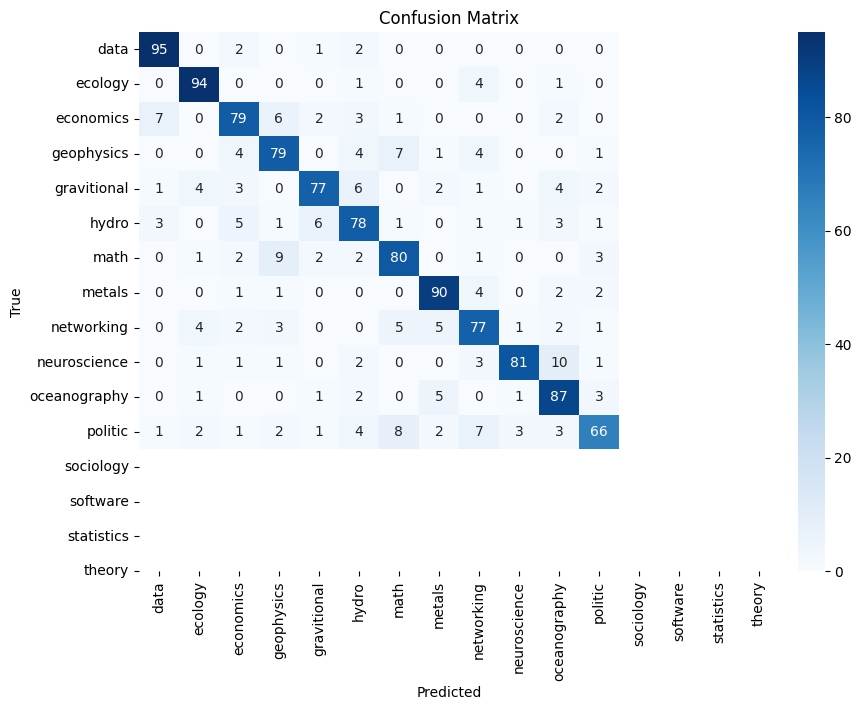

In [24]:
print(eval_results.metrics)
# Output evaluation results
print(f"Accuracy: {eval_results.metrics['test_accuracy']:.4f}")
print(f"F1-micro: {eval_results.metrics['test_f1_micro']:.4f}")
print(f"F1-macro: {eval_results.metrics['test_f1_macro']:.4f}")

# Extract predictions and true labels
pred_labels = np.argmax(eval_results.predictions, axis=1)
true_labels = eval_results.label_ids

# Compute and display Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(label2id.keys()), yticklabels=list(label2id.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Corpus: NSF

### Data load

In [16]:
ds_source = "data/NSF.csv"
model_dir = "./model_NSF"

# Load dataset
data, label2id, id2label = load_and_split_dataset(ds_source)
qt_labels = len(label2id)
print("Training size:", len(data["train"]))
print("Validation size:", len(data["validation"]))
print("Testing size:", len(data["test"]))

Training size: 7366
Validation size: 1052
Testing size: 2106


Labels mapping

In [17]:
print(id2label)
print(label2id)

{0: 'data', 1: 'ecology', 2: 'economics', 3: 'geophysics', 4: 'gravitional', 5: 'hydro', 6: 'math', 7: 'metals', 8: 'networking', 9: 'neuroscience', 10: 'oceanography', 11: 'politic', 12: 'sociology', 13: 'software', 14: 'statistics', 15: 'theory'}
{'data': 0, 'ecology': 1, 'economics': 2, 'geophysics': 3, 'gravitional': 4, 'hydro': 5, 'math': 6, 'metals': 7, 'networking': 8, 'neuroscience': 9, 'oceanography': 10, 'politic': 11, 'sociology': 12, 'software': 13, 'statistics': 14, 'theory': 15}


Data example

In [18]:
print(data["train"][0])

{'text': 'multiple structural changes with deterministic and stochastic trends', 'label': 2, '__index_level_0__': 2231}


### Preprocess

Tokenizer initialization

In [ ]:
#
# Preprocess
#
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenize_and_print(data["train"][0]["text"], tokenizer)

Tokens: ['mathematical', 'sciences', 'order', 'and', 'disorder', 'in', 'spatial', '##ly', 'distributed', 'systems']
Input IDs: [8045, 4163, 2344, 1998, 8761, 1999, 13589, 2135, 5500, 3001]
Tokens with Special Tokens: ['[CLS]', 'mathematical', 'sciences', 'order', 'and', 'disorder', 'in', 'spatial', '##ly', 'distributed', 'systems', '[SEP]']
Encoded output: {'input_ids': tensor([[  101,  8045,  4163,  2344,  1998,  8761,  1999, 13589,  2135,  5500,
          3001,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


Apply tokenizer to the dataset.

In [ ]:
tokenized_data = data.map(lambda example: preprocess_function(example, tokenizer), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

### Train

In [ ]:
#
# Train
#
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=qt_labels, id2label=id2label, label2id=label2id
)

training_args = TrainingArguments(
    output_dir=model_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    push_to_hub=False,  # Disable pushing to the hub
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,No log,0.613543,0.829848,0.770706,0.829848
2,1.191600,0.462814,0.850760,0.839154,0.850760


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,No log,0.613543,0.829848,0.770706,0.829848
2,1.191600,0.462814,0.850760,0.839154,0.850760
3,0.437500,0.447553,0.867871,0.856609,0.867871
4,0.253500,0.447851,0.873574,0.862060,0.873574


Save the model

In [ ]:
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

### Inference

This time we are going to compute the metrics of the test set in a different way of we have computed in the first example (Dmoz-Science). Now we are going to use the saved trained model instead of just use the Trainer.

Predict

In [ ]:
# Load the trained model and tokenizer from your local directory
classifier = pipeline("text-classification", model=model_dir)

# Make predictions
predictions = []
labels = []

for example in data["test"]:
    text = example["text"]
    label = example["label"]
    labels.append(label)

    # Get model prediction
    pred = classifier(text)[0]  # We take the first prediction (since classifier returns a list of predictions)
    predictions.append(pred["label"])

Results

Accuracy: 0.8704
F1-micro: 0.8704
F1-macro: 0.8718


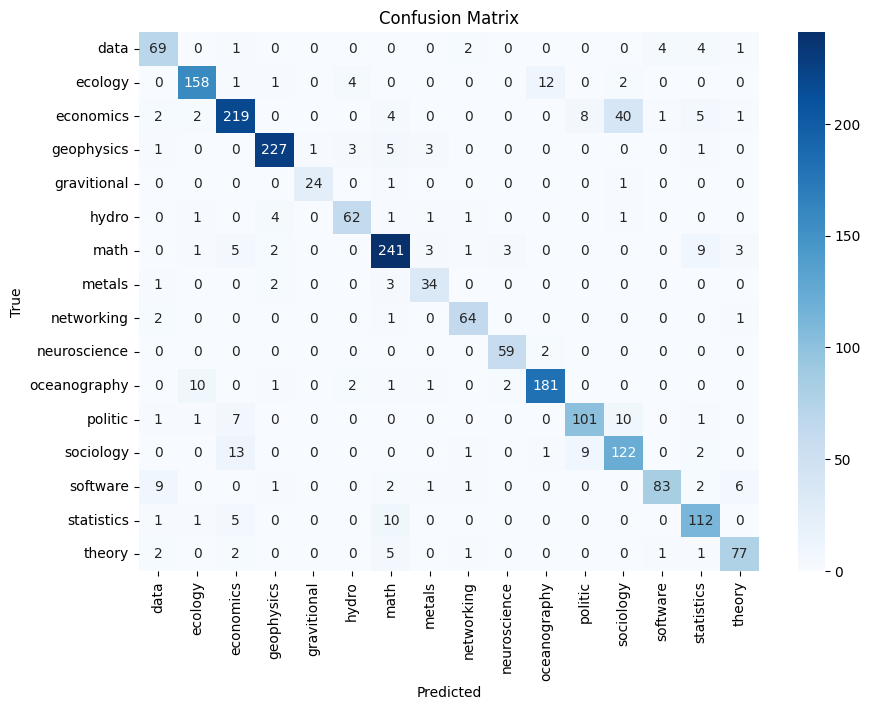

In [23]:
# Convert labels and predictions to numeric
labels = np.array(labels)
predictions = np.array([label2id[pred] for pred in predictions])

# # Calculate F1-micro and F1-macro
accuracy = accuracy_score(labels, predictions)
f1_micro = f1_score(labels, predictions, average='micro')
f1_macro = f1_score(labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-micro: {f1_micro:.4f}")
print(f"F1-macro: {f1_macro:.4f}")

# Compute the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
unique_labels = list(label2id.keys())
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()